# New to Gaussian Processes?

Fantastic that you're here! This notebook is designed to be a gentle
introduction to the mathematics of Gaussian processes (GPs). No prior
knowledge of Bayesian inference or GPs is assumed, and this notebook is
self-contained. At a high level, we begin by introducing Bayes' theorem and
its implications within probabilistic modelling. We then proceed to introduce
the Gaussian random variable along with its multivariate form. We conclude by
showing how this notion can be extended to GPs.

## Bayes' Theorem


A probabilistic modelling task is comprised of an observed dataset
$\mathbf{y}$ for which we construct a model. The parameters $\theta$ of our
model are unknown, and our goal is to conduct inference to determine their
range of likely values. To achieve this, we apply Bayes' theorem
$$
\begin{align}
    \label{eq:BayesTheorem}
    p(\theta\,|\, \mathbf{y}) = \frac{p(\theta)p(\mathbf{y}\,|\,\theta)}{p(\mathbf{y})} = \frac{p(\theta)p(\mathbf{y}\,|\,\theta)}{\int_{\theta}p(\mathbf{y}, \theta)\mathrm{d}\theta}\,,
\end{align}
$$
where $p(\mathbf{y}\,|\,\theta)$ denotes the _likelihood_, or model, and
quantifies how likely the observed dataset $\mathbf{y}$ is, given the
parameter estimate $\theta$. The _prior_ distribution $p(\theta)$ reflects our
initial beliefs about the value of $\theta$ before observing data, whilst the
_posterior_ $p(\theta\,|\, \mathbf{y})$ gives an updated estimate of the
parameters' value, after observing $\mathbf{y}$. The _marginal likelihood_, or
Bayesian model evidence, $p(\mathbf{y})$ is the probability of the observed
data under all possible hypotheses that our prior model can generate. Within
Bayesian model selection, this property makes the marginal log-likelihood an
indispensable tool. Selecting models under this criterion places a higher
emphasis on models that can generalise better to new data points.

When the posterior distribution belongs to the same family of probability
distributions as the prior, we describe the prior and the likelihood as
_conjugate_ to each other. Such a scenario is convenient in Bayesian inference
as it allows us to derive closed-form expressions for the posterior
distribution. When the likelihood function is a member of the exponential
family, then there exists a conjugate prior. However, the conjugate prior may
not have a form that precisely reflects the practitioner's belief surrounding
the parameter. For this reason, conjugate models seldom appear; one exception
to this is GP regression that we present fully in our [Regression notebook](https://gpjax.readthedocs.io/en/latest/examples/regression.html).

For models that do not contain a conjugate prior, the marginal log-likelihood
must be calcualted to normalise the posterior distribution and ensure it
integrates to 1. For models with a single, 1-dimensional parameter, it may be
possible to compute this integral analytically or through a quadrature scheme,
such as Gauss-Hermite. However, in machine learning, the dimensionality of
$\theta$ is often large and the corresponding integral required to compute
$p(\mathbf{y})$ quickly becomes intractable as the dimension grows. Techniques
such as Markov Chain Monte Carlo and variational inference allow us to
approximate integrals such as the one seen in $p(\mathbf{y})$.

Once a posterior distribution has been obtained, we can make predictions at
new points $\mathbf{y}^{\star}$ through the _posterior predictive
distribution_. This is achieved by integrating out the parameter set $\theta$
from our posterior distribution through
$$
\begin{align}
    p(\mathbf{y}^{\star}\,|\, \mathbf{y}) & = \int p(\mathbf{y}^{\star},\theta \,|\,  \mathbf{y} )\mathrm{d}\theta \\
    & = \int p(\mathbf{y}^{\star} \,|\, \theta, \mathbf{y} ) p(\theta\,|\, \mathbf{y})\mathrm{d}\theta\,.
\end{align}
$$
As with the marginal log-likelihood, evaluating this quantity requires
computing an integral which may not be tractable, particularly when $\theta$
is high-dimensional.

It is difficult to communicate statistics directly through a posterior
distribution, so we often compute and report moments of the posterior
distribution. Most commonly, we report the first moment and the centred second
moment
$$
\begin{alignat}{2}
    \mu  = \mathbb{E}[\theta\,|\,\mathbf{y}]  & = \int \theta
    p(\theta\,|\,\mathbf{y})\mathrm{d}\theta &\\
    \sigma^2  = \mathbb{V}[\theta\,|\,\mathbf{y}] & = \int \left(\theta -
    \mathbb{E}[\theta\,|\,\mathbf{y}]\right)^2p(\theta\,|\,\mathbf{y})\mathrm{d}\theta&\,.
\end{alignat}
$$
Through this pair of statistics, we can communicate our beliefs about the most
likely value of $\theta$ i.e., $\mu$, and the uncertainty $\sigma$ around the
expected value. However, as with the marginal log-likelihood and predictive
posterior distribution, computing these statistics again requires a
potentially intractable integral.

## Gaussian random variables

We begin our review with the simplest case; a univariate Gaussian random
variable. For a random variable $y$, let $\mu\in\mathbb{R}$ be a mean scalar
and $\sigma^2\in\mathbb{R}_{>0}$ a variance scalar. If $y$ is a Gaussian
random variable, then the density of $y$ is
$$
\begin{align}
    \mathcal{N}(y\,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y-\mu)^2}{2\sigma^{2}}\right)\,.
\end{align}
$$
We can plot three different parameterisations of this density.

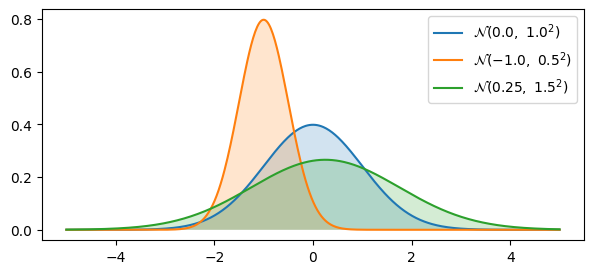

In [1]:
import distrax as dx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import confidence_ellipse

ud1 = dx.Normal(0.0, 1.0)
ud2 = dx.Normal(-1.0, 0.5)
ud3 = dx.Normal(0.25, 1.5)

xs = jnp.linspace(-5.0, 5.0, 500)

fig, ax = plt.subplots(figsize=(7, 3))
for d in [ud1, ud2, ud3]:
    ax.plot(
        xs,
        jnp.exp(d.log_prob(xs)),
        label=f"$\mathcal{{N}}({{{float(d.mean())}}},\  {{{float(d.stddev())}}}^2)$",
    )
    ax.fill_between(xs, jnp.zeros_like(xs), jnp.exp(d.log_prob(xs)), alpha=0.2)
ax.legend(loc="best")

A Gaussian random variable is uniquely defined in distribution by its mean
$\mu$ and variance $\sigma^2$ and we therefore write $y\sim\mathcal{N}(\mu,
\sigma^2)$ when describing a Gaussian random variable. We can compute
these two quantities by
$$
\begin{align}
    \mathbb{E}[y] = \mu\,, \quad \quad \mathbb{E}\left[(y-\mu)^2\right] =\sigma^2\,.
\end{align}
$$
Extending this concept to vector-valued random variables reveals the
multivariate Gaussian random variables which brings us closer to the full
definition of a GP.

Let $\mathbf{y}$ be a $D$-dimensional random variable, $\boldsymbol{\mu}$ be a
$D$-dimensional mean vector and $\boldsymbol{\Sigma}$ be a $D\times D$
covariance matrix. If $\mathbf{y}$ is a Gaussian random variable, then the
density of $\mathbf{y}$ is
$$
\begin{align}
    \mathcal{N}(\mathbf{y}\,|\, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{2\pi}^{D/2} \lvert\boldsymbol{\Sigma}\rvert^{1/2}} \exp\left(-\frac{1}{2} \left(\mathbf{y} - \boldsymbol{\mu}\right)^T \boldsymbol{\Sigma}^{-1} \left(\mathbf{y}-\boldsymbol{\mu}\right) \right) \,.
\end{align}
$$
Three example parameterisations of this can be visualised below where $\rho$
determines the correlation of the multivariate Gaussian.

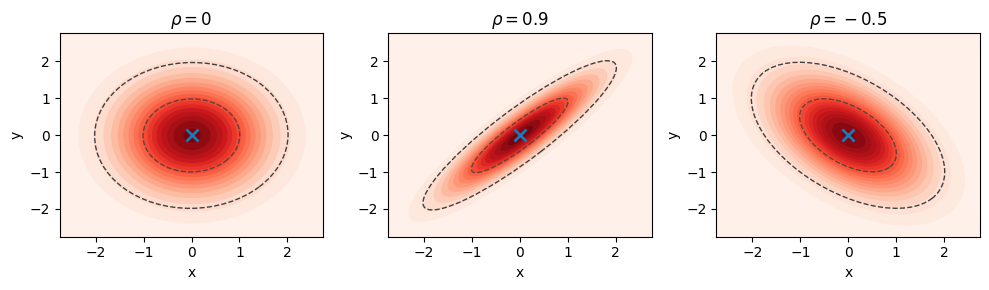

In [2]:
key = jr.PRNGKey(123)

d1 = dx.MultivariateNormalFullCovariance(jnp.zeros(2), jnp.eye(2))
d2 = dx.MultivariateNormalTri(
    jnp.zeros(2), jnp.linalg.cholesky(jnp.array([[1.0, 0.9], [0.9, 1.0]]))
)
d3 = dx.MultivariateNormalTri(
    jnp.zeros(2), jnp.linalg.cholesky(jnp.array([[1.0, -0.5], [-0.5, 1.0]]))
)

dists = [d1, d2, d3]

xvals = jnp.linspace(-5.0, 5.0, 500)
yvals = jnp.linspace(-5.0, 5.0, 500)

xx, yy = jnp.meshgrid(xvals, yvals)

pos = jnp.empty(xx.shape + (2,))
pos.at[:, :, 0].set(xx)
pos.at[:, :, 1].set(yy)

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=3, tight_layout=True)
titles = [r"$\rho = 0$", r"$\rho = 0.9$", r"$\rho = -0.5$"]

for a, t, d in zip([ax0, ax1, ax2], titles, dists):
    d_prob = d.prob(jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])).reshape(
        xx.shape
    )
    cntf = a.contourf(xx, yy, jnp.exp(d_prob), levels=20, antialiased=True, cmap="Reds")
    for c in cntf.collections:
        c.set_edgecolor("face")
    a.set_xlim(-2.75, 2.75)
    a.set_ylim(-2.75, 2.75)
    samples = d.sample(seed=key, sample_shape=(5000,))
    xsample, ysample = samples[:, 0], samples[:, 1]
    confidence_ellipse(
        xsample, ysample, a, edgecolor="#3f3f3f", n_std=1.0, linestyle="--", alpha=0.8
    )
    confidence_ellipse(
        xsample, ysample, a, edgecolor="#3f3f3f", n_std=2.0, linestyle="--"
    )
    a.plot(0, 0, "x", color="tab:blue", markersize=8, mew=2)
    a.set(xlabel="x", ylabel="y", title=t)

Extending the intuition given for the moments of a univariate Gaussian random
variables, we can obtain the mean and covariance by
$$
\begin{align}
    \mathbb{E}[\mathbf{y}] = \boldsymbol{\mu}\,, \quad \operatorname{Cov}(\mathbf{y}) & =\mathbb{E}\left[(\mathbf{y} - \boldsymbol{\mu})(\mathbf{y} - \boldsymbol{\mu})^{\top}\right] \\
    & = \mathbb{E}[\mathbf{y}^2] - \mathbb{E}[\mathbf{y}]^2 \\
    & = \boldsymbol{\Sigma}\,.
\end{align}
$$
The covariance matrix is a symmetric positive definite matrix that generalises
the notion of variance to multiple dimensions. The matrix's diagonal entries
contain the variance of each element, whilst the off-diagonal entries quantify
the degree to which the respective pair of random variables are linearly
related; this quantity is called the _covariance_.

Assuming a Gaussian likelihood function in a Bayesian model is attractive as
the mean and variance parameters are highly interpretable. This makes prior
elicitation straightforward as the parameters' value can be intuitively
contextualised within the scope of the problem at hand. Further, in models
where the posterior distribution is Gaussian, we again use the distribution's
mean and variance to describe our prediction and corresponding uncertainty
around a given event occurring.

Not only are Gaussian random variables highly interpretable, but linear
operations involving them lead to analytical solutions. An example of this
that will be useful in the sequel is the marginalisation and conditioning
property of sets of Gaussian random variables. We will present these two
results now for a pair of Gaussian random variables, but it should be stressed
that these results hold for any finite set of Gaussian random variables.

For a pair of random variables $\mathbf{x}$ and $\mathbf{y}$ defined on the
same support, the distribution over them both is known as the _joint
distribution_. The joint distribution $p(\mathbf{x}, \mathbf{y})$ quantifies
the probability of two events, one from $p(\mathbf{x})$ and another from
$p(\mathbf{y})$, occurring at the same time. We visualise this idea below.

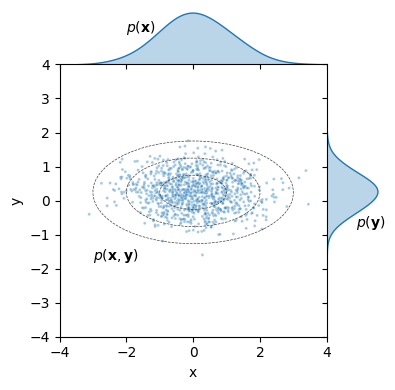

In [3]:
n = 1000
x = dx.Normal(loc=0.0, scale=1.0).sample(seed=key, sample_shape=(n,))
key, subkey = jr.split(key)
y = dx.Normal(loc=0.25, scale=0.5).sample(seed=subkey, sample_shape=(n,))
key, subkey = jr.split(subkey)
xfull = dx.Normal(loc=0.0, scale=1.0).sample(seed=subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
yfull = dx.Normal(loc=0.25, scale=0.5).sample(seed=subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
df = pd.DataFrame({"x": x, "y": y, "idx": jnp.ones(n)})

g = sns.jointplot(
    data=df,
    x="x",
    y="y",
    hue="idx",
    marker=".",
    space=0.0,
    xlim=(-4.0, 4.0),
    ylim=(-4.0, 4.0),
    height=4,
    marginal_ticks=False,
    legend=False,
    marginal_kws={
        "fill": True,
        "linewidth": 1,
        "color": "#A60628",
        "alpha": 0.3,
        "bw_adjust": 2,
    },
    joint_kws={"color": "#A60628", "size": 3.5, "alpha": 0.4},
)
g.ax_joint.annotate(text=r"$p(\mathbf{x}, \mathbf{y})$", xy=(-3, -1.75))
g.ax_marg_x.annotate(text=r"$p(\mathbf{x})$", xy=(-2.0, 0.225))
g.ax_marg_y.annotate(text=r"$p(\mathbf{y})$", xy=(0.4, -0.78))
confidence_ellipse(
    xfull,
    yfull,
    g.ax_joint,
    edgecolor="#3f3f3f",
    n_std=1.0,
    linestyle="--",
    linewidth=0.5,
)
confidence_ellipse(
    xfull,
    yfull,
    g.ax_joint,
    edgecolor="#3f3f3f",
    n_std=2.0,
    linestyle="--",
    linewidth=0.5,
)
confidence_ellipse(
    xfull,
    yfull,
    g.ax_joint,
    edgecolor="#3f3f3f",
    n_std=3.0,
    linestyle="--",
    linewidth=0.5,
)

Formmally, we can define this by letting $p(\mathbf{x}, \mathbf{y})$ be the
joint probability distribution defined over
$\mathbf{x}\sim\mathcal{N}(\boldsymbol{\mu}_{\mathbf{x}}, \boldsymbol{\Sigma}_{\mathbf{xx}})$ and
$\mathbf{y}\sim\mathcal{N}(\boldsymbol{\mu}_{\mathbf{y}}, \boldsymbol{\Sigma}_{\mathbf{yy}})$.
We define the joint distribution as
$$
\begin{align}
    p\left(\begin{bmatrix}
        \mathbf{x} \\ \mathbf{y}
    \end{bmatrix}\right) = \mathcal{N}\left(\begin{bmatrix}
        \boldsymbol{\mu}_{\mathbf{x}} \\ \boldsymbol{\mu}_{\mathbf{y}}
    \end{bmatrix}, \begin{bmatrix}
        \boldsymbol{\Sigma}_{\mathbf{xx}}, \boldsymbol{\Sigma}_{\mathbf{xy}} \\
        \boldsymbol{\Sigma}_{\mathbf{yx}}, \boldsymbol{\Sigma}_{\mathbf{yy}}
    \end{bmatrix} \right)\,,
\end{align}
$$
where $\boldsymbol{\Sigma}_{\mathbf{x}\mathbf{y}}$ is the cross-covariance
matrix of $\mathbf{x}$ and $\mathbf{y}$.

When presented with a joint distribution, two tasks that we may wish to
perform are _marginalisation_ and _conditioning_. For a joint distribution
$p(\mathbf{x}, \mathbf{y})$ where we are interested only in $p(\mathbf{x})$,
we must integrate over all possible values of $\mathbf{y}$ to obtain
$p(\mathbf{x})$. This process is marginalisation. Conditioning allows us to
evaluate the probability of one random variable, given that the other random
variable is fixed. For a joint Gaussian distribution, marginalisation and
conditioning have analytical expressions where the resulting distribution is
also a Gaussian random variable.

For a joint Gaussian random variable, the marginalisation of $\mathbf{x}$ or
$\mathbf{y}$ is given by
$$
\begin{alignat}{3}
    & \int p(\mathbf{x}, \mathbf{y})\mathrm{d}\mathbf{y} && = p(\mathbf{x})
    && = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{x}},
    \boldsymbol{\Sigma}_{\mathbf{xx}}) \\
    & \int p(\mathbf{x}, \mathbf{y})\mathrm{d}\mathbf{x} && = p(\mathbf{y})
    && = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{y}},
    \boldsymbol{\Sigma}_{\mathbf{yy}})\,.
\end{alignat}
$$
The conditional distributions are given by
$$
\begin{align}
    p(\mathbf{x}\,|\, \mathbf{y}) & = \mathcal{N}\left(\boldsymbol{\mu}_{\mathbf{x}} + \boldsymbol{\Sigma}_{\mathbf{xy}}\boldsymbol{\Sigma}_{\mathbf{yy}}^{-1}(\mathbf{y}-\boldsymbol{\mu}_{\mathbf{y}}), \boldsymbol{\Sigma}_{\mathbf{xx}}-\boldsymbol{\Sigma}_{\mathbf{xy}}\boldsymbol{\Sigma}_{\mathbf{yy}}^{-1}\boldsymbol{\Sigma}_{\mathbf{yx}}\right)\\
    p(\mathbf{y}\,|\, \mathbf{x}) & = \mathcal{N}\left(\boldsymbol{\mu}_{\mathbf{y}} + \boldsymbol{\Sigma}_{\mathbf{yx}}\boldsymbol{\Sigma}_{\mathbf{xx}}^{-1}(\mathbf{x}-\boldsymbol{\mu}_{\mathbf{x}}), \boldsymbol{\Sigma}_{\mathbf{yy}}-\boldsymbol{\Sigma}_{\mathbf{yx}}\boldsymbol{\Sigma}_{\mathbf{xx}}^{-1}\boldsymbol{\Sigma}_{\mathbf{xy}}\right)\,.
\end{align}
$$

Within this section, we have introduced the idea of multivariate Gaussian
random variables and presented some key results concerning their properties.
In the following section, we will lift our presentation of Gaussian random
variables to GPs.

## Gaussian processes

When transitioning from Gaussian random variables to GP there is a shift in
thought required to parse the forthcoming material. Firstly, to be consistent
with the general literature, we hereon use $\mathbf{X}$ to denote an observed
vector of data points, not a random variable as has been true up until now. To
distinguish between matrices and vectors, we use bold upper case characters
e.g., $\mathbf{X}$ for matrices, and bold lower case characters for vectors
e.g., $\mathbf{x}$.

We are interested in modelling supervised learning problems, where we have $n$
observations $\mathbf{y}=\{y_1, y_2,\ldots ,y_n\}\subset\mathcal{Y}$ at
corresponding inputs
$\mathbf{X}=\{\mathbf{x}_1,\mathbf{x}_2,\ldots,\mathbf{x}_n\}\subset\mathcal{X}$.
We aim to capture the relationship between $\mathbf{X}$ and $\mathbf{y}$ using
a model $f$ with which we may make predictions at an unseen set of test points
$\mathbf{X}^{\star}\subset\mathcal{X}$. We formalise this by
$$
\begin{align}
    y = f(\mathbf{X}) + \varepsilon\,,
\end{align}
$$
where $\varepsilon$ is an observational noise term. We collectively refer to
$(\mathbf{X}, \mathbf{y})$ as the _training data_ and $\mathbf{X}^{\star}$ as
the set of _test points_.
This process is visualised below

![](figs/generating_process.png)

As we shall go on to see, GPs offer an appealing workflow for scenarios such
as this, all under a Bayesian framework.

We write a GP $f(\cdot) \sim \mathcal{GP}(\mu(\cdot), k(\cdot, \cdot))$ with
mean function $\mu: \mathcal{X} \rightarrow \mathbb{R}$ and
$\boldsymbol{\theta}$-parameterised kernel
$k: \mathcal{X} \times \mathcal{X}\rightarrow \mathbb{R}$.
When evaluating the GP on a finite set of points
$\mathbf{X}\subset\mathcal{X}$, $k$ gives rise to the Gram matrix
$\mathbf{K}_{ff}$ such that the $(i, j)^{\text{th}}$ entry of the matrix is
given by $[\mathbf{K}_{ff}]_{i, j} = k(\mathbf{x}_i, \mathbf{x}_j)$. As is
conventional within the literature, we centre our training data and assume
$\mu(\mathbf{X}):= 0$ for all $\mathbf{X}\in\mathbf{X}$. We further drop
dependency on $\boldsymbol{\theta}$ and $\mathbf{X}$ for notational
convenience in the remainder of this article.

We define a joint GP prior over the latent function
$$
\begin{align}
    p(\mathbf{f}, \mathbf{f}^{\star}) = \mathcal{N}\left(\mathbf{0}, \begin{bmatrix}
        \mathbf{K}_{ff} & \mathbf{K}_{fx} \\
        \mathbf{K}_{xf} & \mathbf{K}_{xx}
    \end{bmatrix}\right)\,,
\end{align}
$$
where $\mathbf{f}^{\star} = f(\mathbf{X}^{\star})$. Conditional on the GP's
latent function $f$, we assume a factorising likelihood generates our
observations
$$
\begin{align}
    p(\mathbf{y}\,|\,\mathbf{f}) = \prod_{i=1}^n p(y_i\,|\, f_i)\,.
\end{align}
$$
Strictly speaking, the likelihood function is
$p(\mathbf{y}\,|\,\phi(\mathbf{f}))$ where $\phi$ is the likelihood function's
associated link function. Example link functions include the probit or
logistic functions for a Bernoulli likelihood and the identity function for a
Gaussian likelihood. We eschew this notation for now as this section primarily
considers Gaussian likelihood functions where the role of $\phi$ is
superfluous. However, this intuition will be helpful for models with a
non-Gaussian likelihood, such as those encountered in
[classification](https://gpjax.readthedocs.io/en/latest/examples/classification.html).

Applying Bayes' theorem \eqref{eq:BayesTheorem} yields the joint posterior distribution over the
latent function
$$
\begin{align}
    p(\mathbf{f}, \mathbf{f}^{\star}\,|\,\mathbf{y}) = \frac{p(\mathbf{y}\,|\,\mathbf{f})p(\mathbf{f},\mathbf{f}^{\star})}{p(\mathbf{y})}\,.
\end{align}
$$

The choice of kernel function that we use to parameterise our GP is an
important modelling decision as the choice of kernel dictates properties such
as differentiability, variance and characteristic lengthscale of the functions
that are admissible under the GP prior. A kernel is a positive-definite
function with parameters $\boldsymbol{\theta}$ that maps pairs of inputs
$\mathbf{X}, \mathbf{X}' \in \mathcal{X}$ onto the real line. We dedicate the
entirity of the [Kernel Guide
notebook](https://gpjax.readthedocs.io/en/latest/examples/kernels.html) to
exploring the different GPs each kernel can yield.

## Gaussian process regression

When the likelihood function is a Gaussian distribution
$p(y_i\,|\, f_i) = \mathcal{N}(y_i\,|\, f_i, \sigma_n^2)$,
marginalising $\mathbf{f}$ from the joint posterior to obtain
the posterior predictive distribution is exact
$$
\begin{align}
    p(\mathbf{f}^{\star}\,|\,\mathbf{y}) & = \int p(\mathbf{f}, \mathbf{f}^{\star}\,|\, \mathbf{y})\mathrm{d}\mathbf{f} \\
    & = \mathcal{N}(\mathbf{f}^{\star}\,|\,\boldsymbol{\mu}_{\,|\,\mathbf{y}}, \Sigma_{\,|\,\mathbf{y}})\,,
\end{align}
$$
where
$$
\begin{align}
    \boldsymbol{\mu}_{\,|\,\mathbf{y}} & = \mathbf{K}_{xf}\left(\mathbf{K}_{ff} + \sigma_n\mathbf{I}_n \right)^{-1}\mathbf{y}\\
    \Sigma_{\,|\,\mathbf{y}} & = \mathbf{K}_{\star\star} - \mathbf{K}_{xf}\left(\mathbf{K}_{ff} + \sigma_n^2\mathbf{I}_n\right)^{-1}\mathbf{K}_{fx} \,.
\end{align}
$$
Further, the log of the  marginal likelihood of the GP can
be analytically expressed as
$$
\begin{align}
        \log p(\mathbf{y}) & = \log\int p(\mathbf{y}\,|\, \mathbf{f})p(\mathbf{f},\mathbf{f}^{\star})\mathrm{d}\mathbf{f}^{\star}  \\
        & = 0.5\left(-\underbrace{\mathbf{y}^{\top}\left(\mathbf{K}_{ff} - \sigma_n^2\mathbf{I}_n \right)^{-1}\mathbf{y}}_{\text{Data fit}} -\underbrace{\log\lvert \mathbf{K}_{ff} + \sigma^2_n\rvert}_{\text{Complexity}} -\underbrace{n\log 2\pi}_{\text{Constant}} \right)\,.
\end{align}
$$

Model selection can be performed for a GP through gradient-based optimisation
of $\log p(\mathbf{y})$ with respect to the kernel's parameters
$\boldsymbol{\theta}$ and the observational noise $\sigma^2_n$. Collectively,
we call these terms the model hyperparameters
$\boldsymbol{\xi} = \{\boldsymbol{\theta},\sigma_n^2\}$
from which the maximum likelihood estimate is given by
$$
\begin{align*}
    \boldsymbol{\xi}^{\star} = \operatorname{argmax}_{\boldsymbol{\xi} \in \Xi} \log p(\mathbf{y})\,.
\end{align*}
$$


Observing the individual terms in the marginal log-likelihood can help
understand exactly why optimising the marginal log-likelihood gives reasonable
solutions. The _data fit_ term is the only component of the marginal
log-likelihood that includes the observed response $\mathbf{y}$ and will
therefore encourage solutions that model the data well. Conversely, the
_complexity_ term contains a determinant operator and therefore measures the
_volume_ of the function space covered by the GP. Whilst a more complex
function has a better chance of modelling the observed data well, this is only
true to a point and functions that are overly complex will overfit the data.
Optimising with respect to the marginal log-likelihood balances these two
objectives when identifying the optimal solution, as visualised below.

![](figs/decomposed_mll.png)

## Conclusions

Within this notebook we have built up the concept of a GP, starting from
Bayes' theorem and the definition of a Gaussian random variable. Using the
ideas presented in this notebook, the user should be in a position to dive
into our [Regression
notebook](https://gpjax.readthedocs.io/en/latest/examples/regression.html) and
start getting their hands on some code. For those looking to learn more about
the underling theory of GPs, an excellent starting point is the [Gaussian
Processes for Machine Learning](http://gaussianprocess.org/gpml/) textbook.
Alternatively, the [thesis of Alexander
Terenin](https://arxiv.org/abs/2202.10613) provides a rigorous exposition of
GPs that served as the inspiration for this notebook.

## System Configuration

In [4]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'

Author: Thomas Pinder

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

matplotlib: 3.3.3
seaborn   : 0.12.2
distrax   : 0.1.2
pandas    : 1.5.2
jax       : 0.4.1

Watermark: 2.3.1

